# Imports

In [74]:
import os
import os.path as osp

import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from src.features.segmentation.transformers_dataset import SegmentationDataset

import albumentations

import transformers
import evaluate

# Dataset

In [75]:
train_batch_size = 8
val_batch_size = 4
pin_memory = True
num_workers = 4

In [76]:
train_images_dir = r"C:\Internship\ITMO_ML\data\weakly_segmented\bubbles_split\test\images"
train_masks_dir = r"C:\Internship\ITMO_ML\data\weakly_segmented\bubbles_split\test\masks"

val_images_dir = r"C:\Internship\ITMO_ML\data\weakly_segmented\bubbles_split\valid\images"
val_masks_dir = r"C:\Internship\ITMO_ML\data\weakly_segmented\bubbles_split\valid\masks"

In [77]:
#train_image_transform = albumentations.Compose([
#    # albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
#])

# train_mask_transform = albumentations.Compose([])

train_augmentation_transform = albumentations.Compose([
    albumentations.RandomCrop(height=512, width=512),
    albumentations.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=30, p=0.5)
])

In [78]:
#val_image_transform = albumentations.Compose([
    # albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
#])

# val_mask_transform = albumentations.Compose([])

# val_augmentation_transform = albumentations.Compose([])

In [79]:
image_processor = transformers.SegformerImageProcessor()

In [80]:
train_dataset = SegmentationDataset(
    images_dir=train_images_dir,
    masks_dir=train_masks_dir,
    #image_transform=train_image_transform,
    #mask_transform=mask_transform,
    augmentation_transform=train_augmentation_transform,
    image_processor=image_processor
)

val_dataset = SegmentationDataset(
    images_dir=val_images_dir,
    masks_dir=val_masks_dir,
    #image_transform=val_image_transform,
    #mask_transform=mask_transform,
    image_processor=image_processor
)

In [81]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 3631
Number of validation examples: 2546


In [82]:
pixel_values, mask = train_dataset[0]
print(pixel_values.shape)
print(mask.shape)

torch.Size([3, 512, 512])
torch.Size([512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


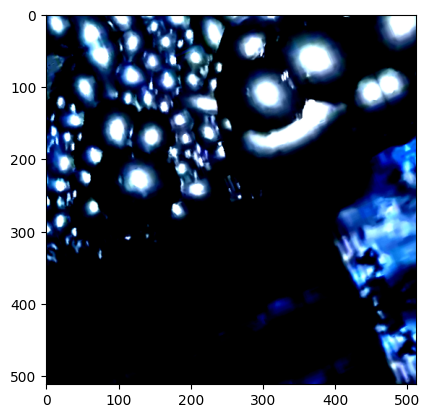

In [83]:
plt.imshow(pixel_values.permute(1,2,0))

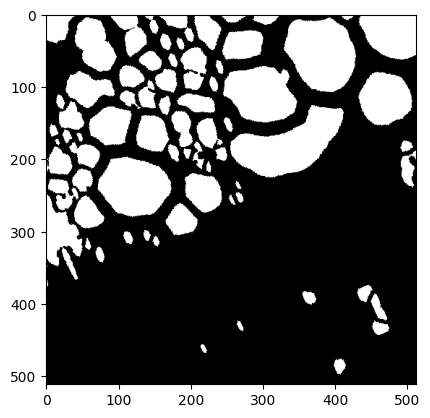

In [84]:
plt.imshow(mask, cmap='gray')

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, pin_memory=pin_memory, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, pin_memory=pin_memory, num_workers=num_workers)

# Model

In [33]:
model = transformers.SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b1-finetuned-ade-512-512")

In [34]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = True
model.to(device)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [35]:
metric = evaluate.load("mean_iou")

In [36]:
epoch_num = 2

In [37]:
model.train()
history = {
    "loss": [],
    "mean_iou": [],
    "mean_accuracy": []
}
for epoch in range(epoch_num):
    print("Epoch:", epoch)
    model.train()
    for batch in tqdm(train_dataloader):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()
    
    model.eval()
    for batch in tqdm(val_dataloader):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:],mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        # note that the metric expects predictions + labels as numpy arrays
        # metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())
        # 
        # metrics = metric._compute(
        #     predictions=predicted.cpu(),
        #     references=labels.cpu(),
        #     num_labels=1,
        #     ignore_index=255,
        #     reduce_labels=False, # we've already reduced the labels ourselves
        # )

    # loss_num = loss.item()
    # print("Loss:", loss_num)
    # history["loss"].append(loss_num)
    # print("Mean_iou:", metrics["mean_iou"])
    # history["mean_iou"].append(metrics["mean_iou"])
    # print("Mean accuracy:", metrics["mean_accuracy"])
    # history["mean_accuracy"].append(metrics["mean_accuracy"])

Epoch: 0


100%|██████████| 637/637 [01:25<00:00,  7.46it/s]


Epoch: 1


100%|██████████| 637/637 [01:22<00:00,  7.72it/s]


In [38]:
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(27, 9))
# 
# ax[0].plot(range(len(history["loss"])), history["loss"])
# ax[0].set_title("loss")
# ax[1].plot(range(len(history["mean_iou"])), history["mean_iou"])
# ax[1].set_title("mean_iou")
# ax[2].plot(range(len(history["mean_accuracy"])), history["mean_accuracy"])
# ax[2].set_title("mean_accuracy")
# plt.show()

In [39]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

In [40]:
save_model(model, path=r"C:\Internship\ITMO_ML\CTCI\checkpoints\segformer\segformer_test\run1\weights_epoch2.pt")

# Results

In [41]:
from PIL import Image

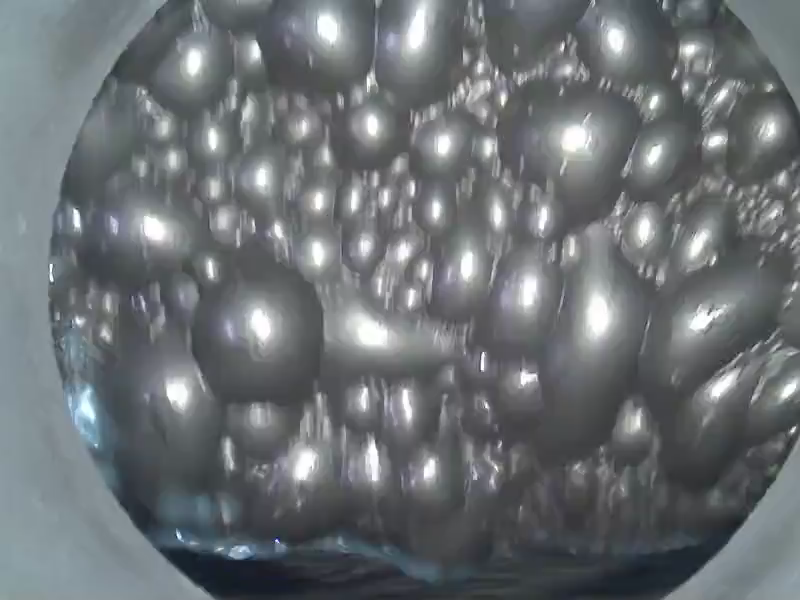

In [42]:
image = Image.open(r"C:\Internship\ITMO_ML\CTCI\data\frame-0.png")
image

In [43]:
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [44]:
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [45]:
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [46]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


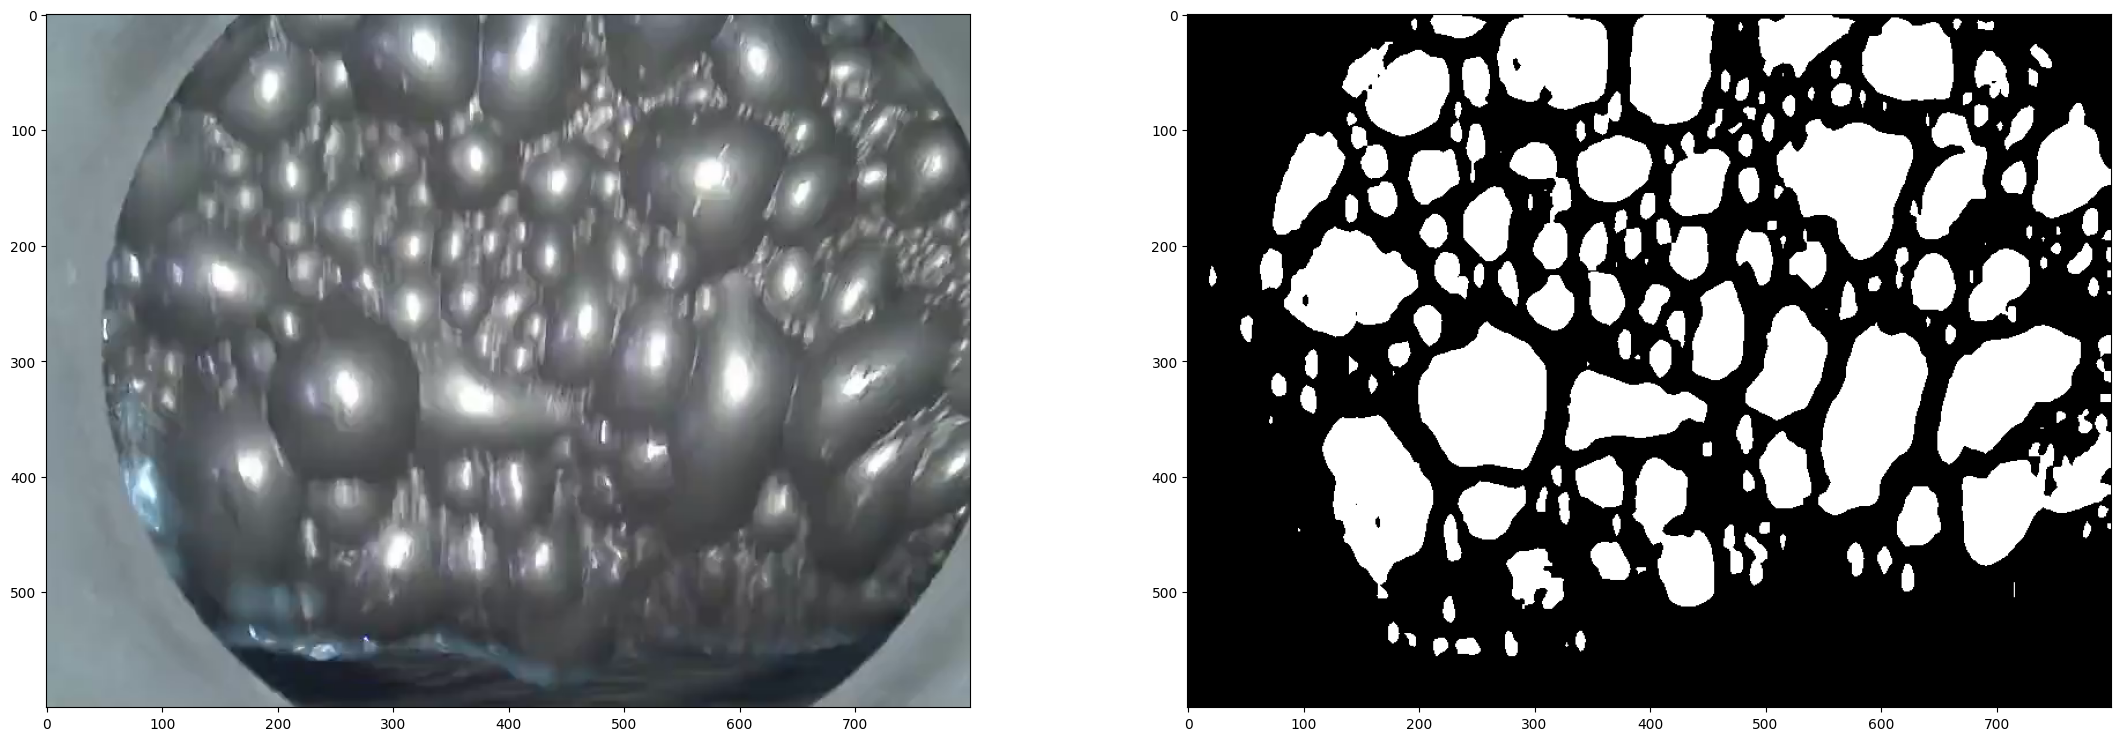

In [48]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(27, 9))

ax[0].imshow(image)
ax[1].imshow(predicted_segmentation_map, cmap="gray")
plt.show()